Import libraries

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import os
import numpy as np

import hopsworks
import joblib
import json

c:\Users\celin_e3kjw6h\miniconda3\envs\fake_news\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project = hopsworks.login()

fs = project.get_feature_store()

2025-01-09 22:35:50,113 INFO: Initializing external client
2025-01-09 22:35:50,115 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-09 22:35:52,047 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1149079


### Selecting features for training

In [3]:
news_propagation_fg = fs.get_feature_group(
    name="news_propagation",
    version=1,
)

In [4]:
selected_features = news_propagation_fg.select_except(["news_id"])

In [5]:
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.91s) 


,average_followers,average_follows,repost_total,post_total,repost_percentage,average_repost,average_favorite,label,news_lifetime,nb_users_10_hours,average_time_difference,retweet_percentage_1_hour
0,625.000000,438.000000,0,1,0.000000,0.000000,0.000000,1,0,1,0.0,1.000000
1,1410.833333,1103.416667,4,10,0.285714,0.285714,6.166667,0,63372,1,0.0,0.071429
2,536.454545,342.909091,979,1,0.998980,9.989796,499.000000,0,0,1,0.0,0.001020
3,223066.000000,178.000000,0,2,0.000000,0.000000,0.000000,0,39416,1,0.0,0.500000
4,74.500000,156.000000,0,2,0.000000,0.000000,0.000000,0,11319,1,0.0,0.500000


In [6]:
feature_view = fs.get_or_create_feature_view(
        name = 'news_propagation_feature_views',
        version = 1,
        labels=["label"],
        query=selected_features,
)

### Split data into training, validation, and test sets

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


### Hyperpameters tuning

In [8]:
tuning = True

In [9]:
# Define the hyperparameter grid
if tuning:
    param_grid = {
        'n_estimators': [25, 50, 100, 150], 
        'max_features': ['sqrt', 'log2', None], 
        'max_depth': [3, 6, 9], 
        'max_leaf_nodes': [3, 6, 9], 
        'min_samples_leaf': [1, 2, 4],
    }

    # Create the XGBoost model object
    model = RandomForestClassifier()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, np.ravel(y_train))

In [10]:
model_dir = "news_propagation_model"
# Save the hyperparameters of the best model as a json file
with open(os.path.join(model_dir, "hyperparameters.json"), "w") as outfile: 
    json.dump(grid_search.best_params_, outfile)


# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 6, 'min_samples_leaf': 2, 'n_estimators': 50}
Best score:  0.7215189873417722


### Train the model with the best hyperparameters

In [11]:
with open(os.path.join(model_dir, "hyperparameters.json")) as json_file:
    best_params = json.load(json_file)
    
random_forest = RandomForestClassifier(max_depth= best_params["max_depth"], 
                                       max_features = best_params["max_features"], 
                                       max_leaf_nodes = best_params["max_leaf_nodes"], 
                                       n_estimators = best_params["n_estimators"],
                                       min_samples_leaf= best_params["min_samples_leaf"],
                                       )

random_forest.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       min_samples_leaf=2, n_estimators=50)

In [12]:
y_pred_train = random_forest.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7569620253164557

In [13]:
y_pred_val = random_forest.predict(X_val)
accuracy_score(y_val, y_pred_val)

0.7610619469026548

### Evaluate the model

In [14]:
y_pred_test = random_forest.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.7192982456140351

In [15]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred_test)
}
metrics

{'accuracy': 0.7192982456140351}

### Confusion matrix

In [16]:
results = confusion_matrix(y_test, y_pred_test)
results

array([[21,  2],
       [14, 20]], dtype=int64)

In [17]:
# Create a DataFrame from the confusion matrix results
df_cm = pd.DataFrame(
    results, 
    ['True Real', 'True Fake'],
    ['Pred Real', 'Pred Fake']
)

# Create and save the confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = sns.heatmap(
    df_cm, 
    annot=True,
    fmt='d',                 # Use integer format for numbers
    cmap='RdPu',             # Use a color palette that works well for binary classification
    annot_kws={'size': 12},  # Increase annotation text size
    cbar=True                # Include color bar
)

# Add title and labels
plt.title('Confusion Matrix for Fake News Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

images_dir = "figures"

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(images_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.close()

### Plot feature importance

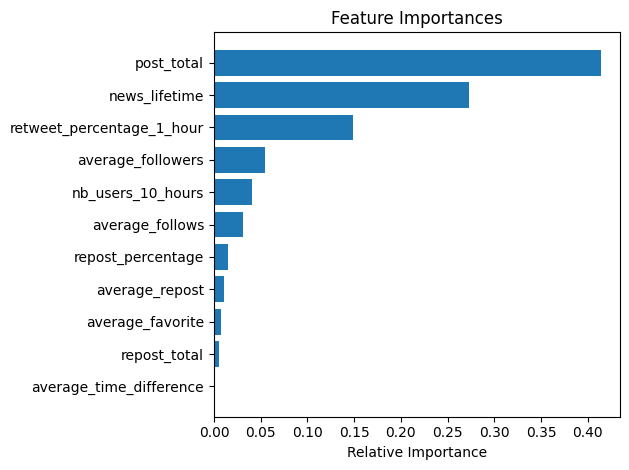

In [18]:
images_dir = 'figures'
importances = random_forest.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.savefig(os.path.join(images_dir, "feature_importance.png"))

### Save the model into Hopsworks

In [19]:
# Get the model registry
mr = project.get_model_registry()

In [20]:
# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary
model_schema.to_dict()# Specify the directory where the model files will be saved

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained classifier as json file
joblib.dump(random_forest, os.path.join(model_dir, "model.joblib"))

['news_propagation_model\\model.joblib']

In [21]:
# Create a model in the model registry
model = mr.python.create_model(
    name="news_propagation_model",
    description="News Propagation Model",
    input_example=X_train.sample(),
    model_schema=model_schema,
    feature_view=feature_view,
    metrics=metrics,
)

# Save the model to the specified directory
model.save(model_dir)

Uploading: 100.000%|██████████| 102/102 elapsed<00:02 remaining<00:0000:03,  1.36it/s]
Uploading: 100.000%|██████████| 65961/65961 elapsed<00:02 remaining<00:003,  1.36it/s]
Uploading: 100.000%|██████████| 195108/195108 elapsed<00:02 remaining<00:00  1.36it/s]
Uploading: 100.000%|██████████| 112/112 elapsed<00:02 remaining<00:00<00:20,  5.18s/it]
Uploading: 100.000%|██████████| 1100/1100 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1149079/models/news_propagation_model/16


Model(name: 'news_propagation_model', version: 16)